In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def gaussian_pyramid(imagen, num_octavas, intv):
  piramide_gaussiana = []

  for i in range(num_octavas):
    octava = []
    sigma = 0.5
    for j in range(intv):
      imagen_suavizada = cv2.GaussianBlur(imagen, (0, 0), sigma)
      #print(imagen_suavizada.shape)
      octava.append(imagen_suavizada)
      # Aumentar sigma para la siguiente imagen de la octava
      sigma *= 2
    piramide_gaussiana.append(octava)

    # Reducir resolucion
    dim = (imagen.shape[1] // 2, imagen.shape[0] // 2)
    imagen = cv2.resize(imagen, dim, interpolation=cv2.INTER_NEAREST)

  # Imprimir
  for octava in piramide_gaussiana:
    i = 0
    fig, ax = plt.subplots(1,intv, figsize=(6,8))
    ax[0].set_title('Espacio de escala')
    for imagen_suavizada in octava:
      ax[i].imshow(imagen_suavizada, cmap='gray')
      ax[i].axis("off")
      i = i + 1
    plt.show()

  return piramide_gaussiana

In [5]:
def dif_gaussianas(piramide_gaussiana):
    dif_gaussiana = []

    for octava in piramide_gaussiana:
        diferencia_octava = []
        for i in range(len(octava) - 1):
            diferencia = octava[i + 1] - octava[i]
            diferencia_octava.append(diferencia)
        dif_gaussiana.append(diferencia_octava)

    # Imprimir
    for octava in dif_gaussiana:
      fig = plt.figure()
      fig.set_size_inches(4, 6)
      plt.title('Diferencias de Gaussianas')
      for diferencia in octava:
        plt.imshow(diferencia, cmap='gray')
        plt.axis("off")
      plt.show()

    return dif_gaussiana

In [6]:
def puntos_clave(imagen, imagen_g):
    sift = cv2.SIFT_create()
    puntos_clave, descriptores = sift.detectAndCompute(imagen_g, None)
    imagen_puntos_clave = cv2.drawKeypoints(imagen, puntos_clave, None)

    plt.imshow(imagen_puntos_clave)
    plt.title('Identificación de puntos clave')
    plt.show()

    return imagen_puntos_clave, puntos_clave, descriptores

In [7]:
def calcular_orientaciones(puntos_clave, descriptores, window, bins_orientaciones):
    orientaciones_keypoints = []

    for i, punto_clave in enumerate(puntos_clave):
        x, y = int(punto_clave.pt[0]), int(punto_clave.pt[1])
        descriptor = descriptores[i].reshape((-1, 8))

        magnitud = np.zeros((window, window))
        orientacion = np.zeros((window, window))

        magnitudes = np.sqrt(descriptor[:, ::2]**2 + descriptor[:, 1::2]**2)
        orientaciones = np.degrees(np.arctan2(descriptor[:, 1::2], descriptor[:, ::2]))
        orientaciones[orientaciones < 0] += 360

        histograma_orientaciones, b_orientaciones = np.histogram(orientaciones.flatten(), bins=bins_orientaciones, range=(0, 360), weights=magnitudes.flatten())
        orientaciones_keypoints.append((x, y, histograma_orientaciones))

    first_keypoint = orientaciones_keypoints[0]
    hist_first_keypoint = first_keypoint[2]

    angulos = np.linspace(0, 360, len(hist_first_keypoint), endpoint=False)
    plt.figure(figsize=(8, 6))
    plt.bar(angulos, hist_first_keypoint, width=360 / len(hist_first_keypoint), align='edge')
    plt.title('Histograma de orientacion')
    plt.xlabel('Angle Bins')
    plt.ylabel('Magnitud')
    plt.show()
    return orientaciones_keypoints

In [8]:
def unir_keypoints(template, imagen, imagen_descriptor, imagen_keypoints):
    # Puntos clave y descriptor de template
    sift = cv2.SIFT_create()
    puntos_clave_template, descriptores_template = sift.detectAndCompute(template, None)

    # BFMatcher (union de los puntos)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptores_template, imagen_descriptor, k=2)
    g_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            g_matches.append(m)

    # Dibujar los emparejamientos
    imagen_union = cv2.drawMatches(template, puntos_clave_template, imagen, imagen_keypoints, g_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return imagen_union, g_matches

In [9]:
# Gaussiana
def sift(archivo_imagen, archivo_template, octavas, interv):
  # Piramida gaussiana
  imagen = cv2.imread(archivo_imagen,1)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagen_g = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  piramide = gaussian_pyramid(imagen_g, octavas, interv)

  # Diferencia de gaussianas
  dif = dif_gaussianas(piramide)

  # Encontrar puntos clave
  img_keypoints, keypoints, descriptor = puntos_clave(imagen, imagen_g)

  # Histograma de orientaciones
  orientaciones = calcular_orientaciones(keypoints, descriptor, 16, 36)

  # Pareo de keypoints
  template = cv2.imread(archivo_template, 0)
  imagen_pareo, buenos_matches = unir_keypoints(template, imagen_g, descriptor, keypoints)
  plt.imshow(imagen_pareo)

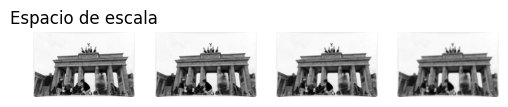

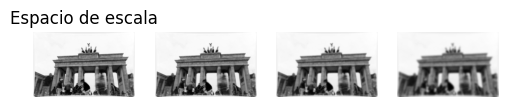

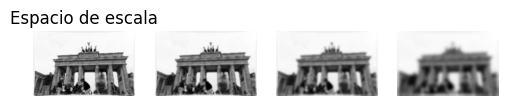

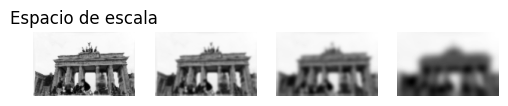

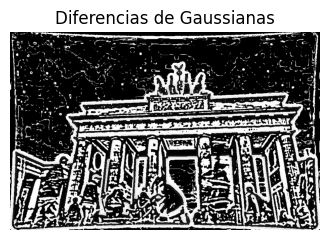

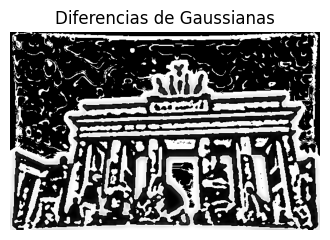

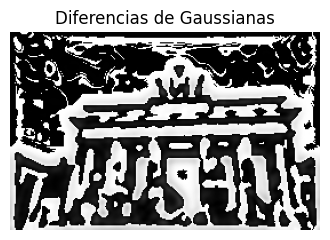

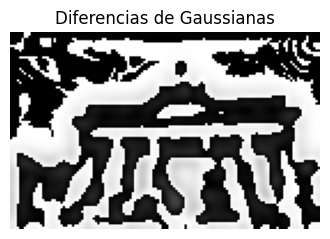

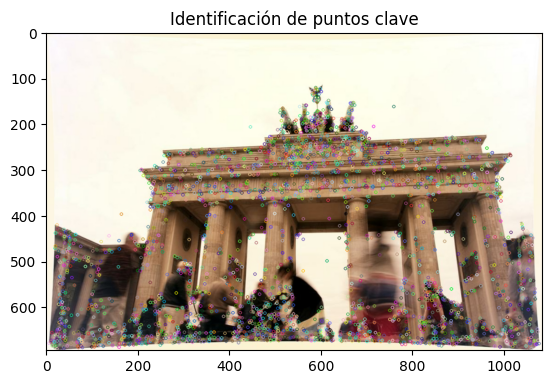

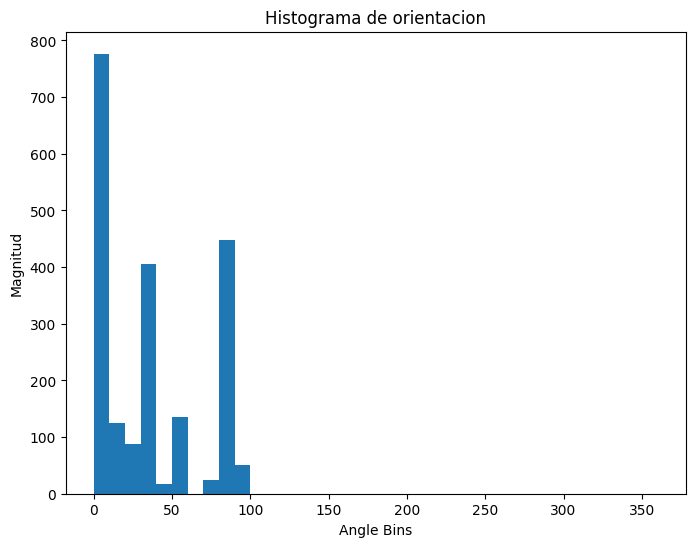

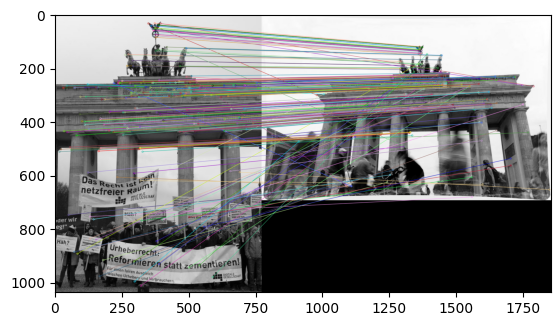

In [12]:
sift('../../IMAGES/00883281_9633489441.jpg', '../../IMAGES/02035158_8518636650.jpg', 4, 4)

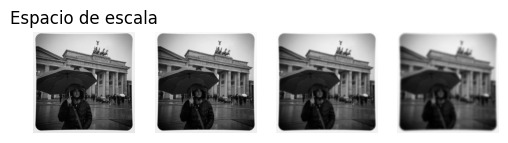

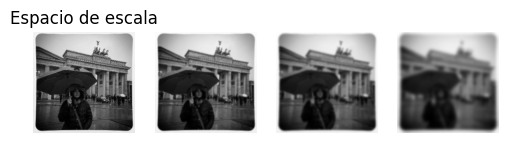

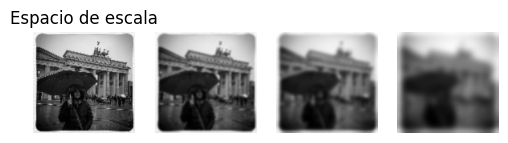

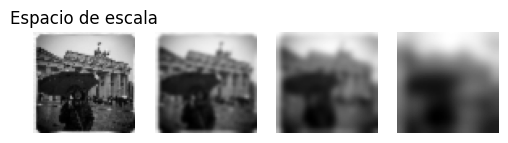

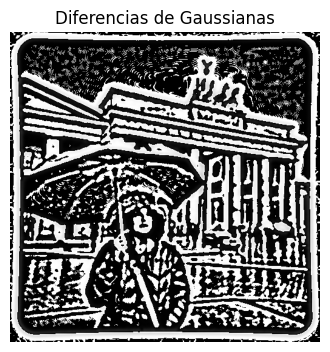

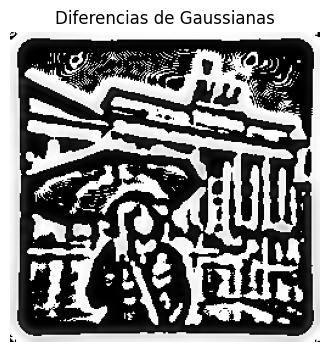

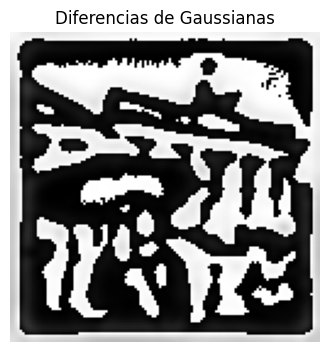

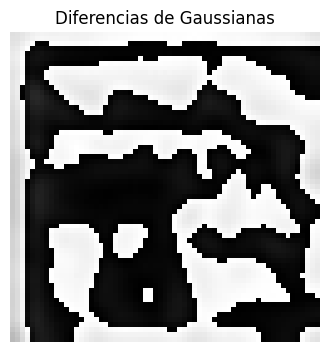

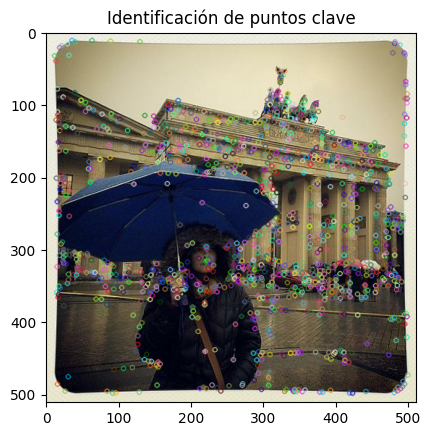

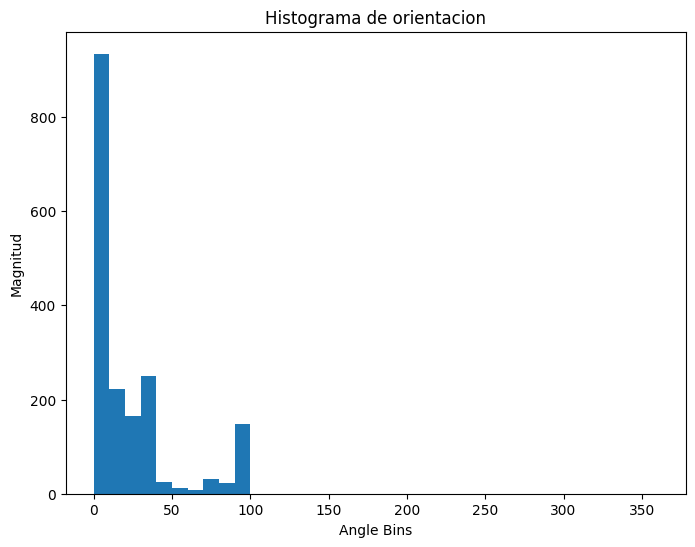

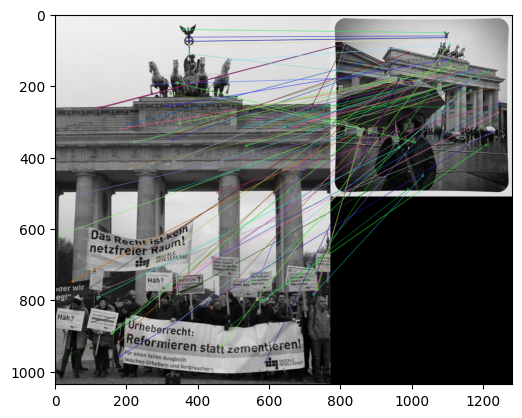

In [15]:
sift('../../IMAGES/04803880_11119539065.jpg', '../../IMAGES/02035158_8518636650.jpg', 4, 4)

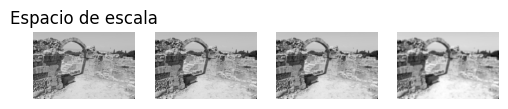

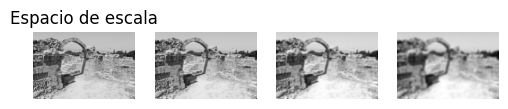

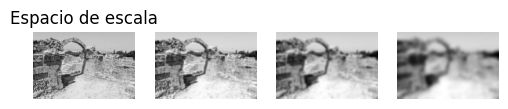

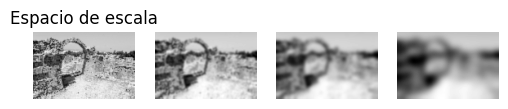

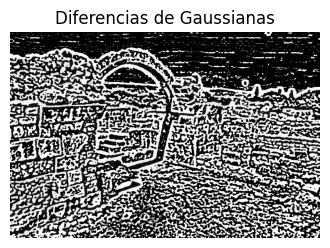

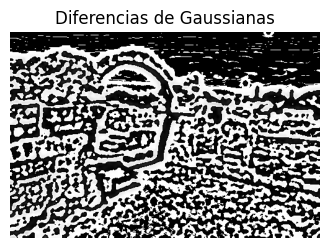

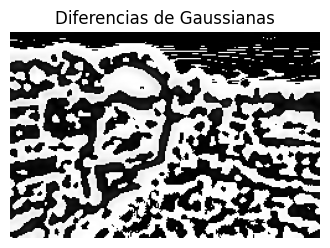

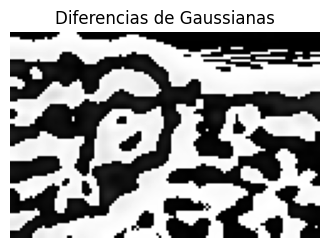

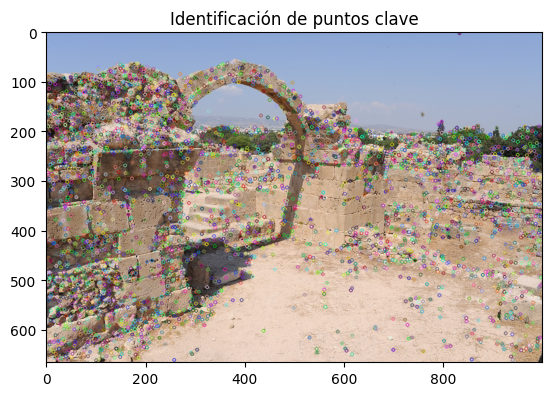

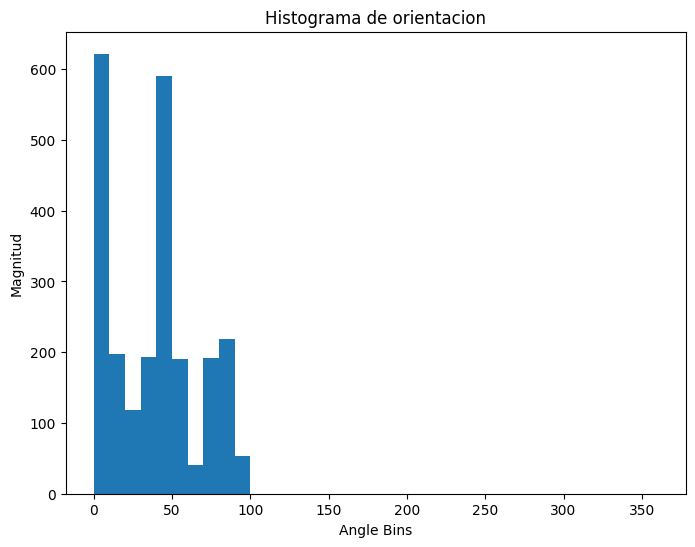

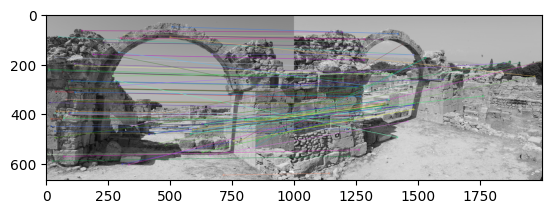

In [16]:
sift('../../IMAGES/DSC_6492.JPG', '../../IMAGES/DSC_6500.JPG', 4, 4)

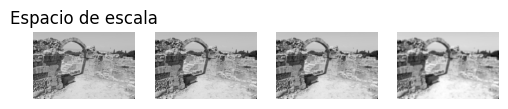

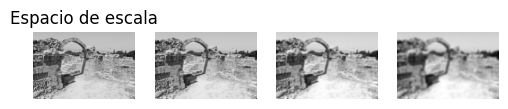

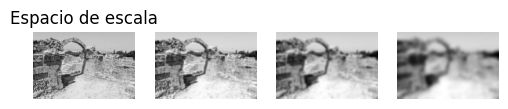

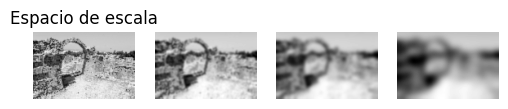

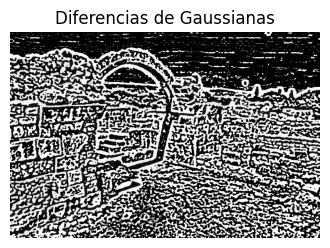

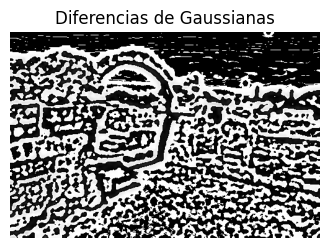

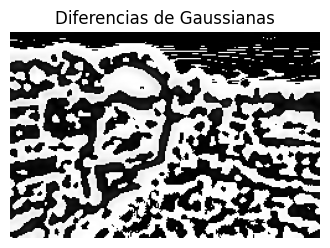

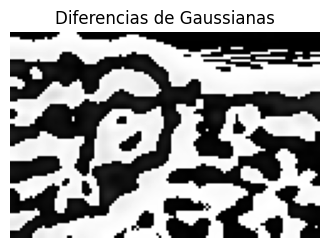

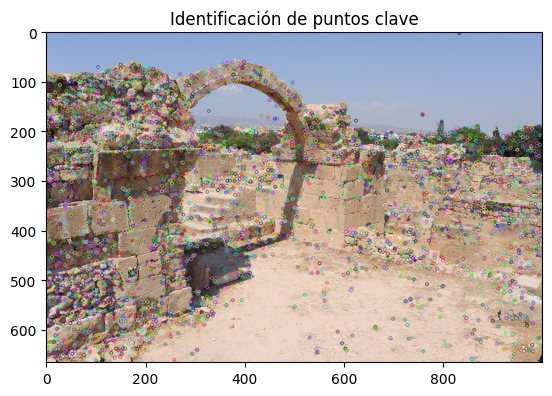

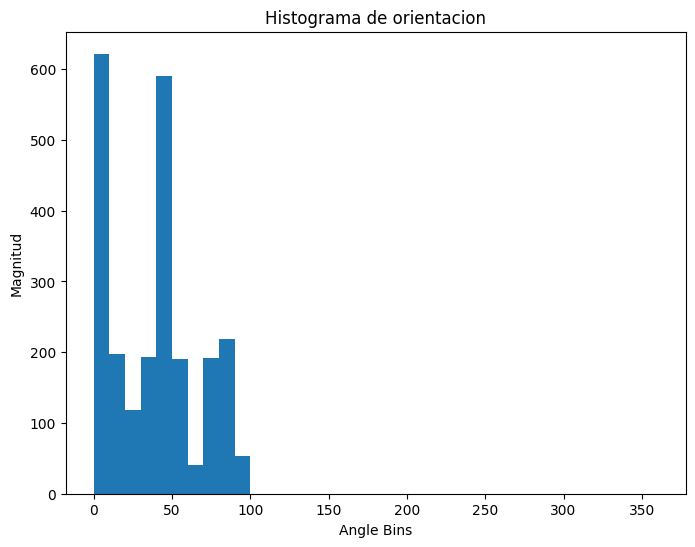

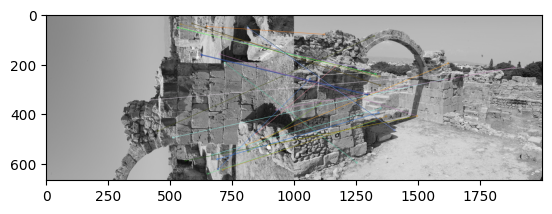

In [17]:
sift('../../IMAGES/DSC_6492.JPG', '../../IMAGES/DSC_6508.JPG', 4, 4)